<h2>Vertical Soundings</h2>

This example uses wrf-python to access data from a wrfout file (here, valid at 0000 UTC 8 October 2016 from the Assignment 1 Hurricane Matthew tutorial case) and MetPy to generate a skew-T, ln-p diagram valid at a user-specified location (by lat/lon).

This example was partially drawn from the MetPy Upper Air Sounding Tutorial (https://unidata.github.io/MetPy/latest/tutorials/upperair_soundings.html) with tweaks to use data from wrf-python rather than to use MetPy's sample data. The sounding generated below is fairly basic; please refer to the MetPy  tutorial for examples of how to add parcel ascent curves, shade CAPE/CIN for surface-based parcels, determine selected lifted parcel parameters, and add a hodograph. Even more is possible by digging in to the MetPy documentation.

<hr>

We start by importing the needed modules. These are drawn from five packages - netCDF4, matplotlib, numpy, wrf (short for wrf-python), and metpy.

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from wrf import (to_np, getvar, ll_to_xy)

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

Open the desired wrfout file (which in this instance contains data only for a single output time):

In [2]:
ncfile = Dataset("wrfout_d01_2016-10-08_00:00:00")

We need six variables from this dataset: pressure, height, temperature, dewpoint, and the u and v wind components. These reference the full list of variables that wrf-python can derive is available at https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.getvar.html.

In [3]:
p = getvar(ncfile, "p", units="hPa")
z = getvar(ncfile, "z", units="m")
t = getvar(ncfile, "tc")
td = getvar(ncfile, "td", units="degC")
u = getvar(ncfile, "uvmet", units="kt")[0,:]
v = getvar(ncfile, "uvmet", units="kt")[1,:]

Specify the latitude and longitude for the skew-T, ln-p diagram. Note that Western Hemisphere longitudes (and Southern Hemisphere latitudes) should be specified as negative values (e.g., lon = -85 indicates 85 deg W longitude). After doing so, we call wrf-python's ll_to_xy helper function to convert the lat/lon to the nearest x, y model grid points. 

We call this helper function because the model variables have dimensions south_north and west_east, which refer to x/y points rather than to lat/lon locations. As a result, we must refer to x/y points when parsing the data to a single location.

In [4]:
lat = 30.0
lon = -80.0

xloc, yloc = to_np(ll_to_xy(ncfile, lat, lon))

Next, we parse each of our variables from being full three-dimensional (x, y, and model level) to a single dimension (model level) at our indicated location. This is done using xarray's sel function. Because xarray variables contain metadata such as units, we do not need to manually provide each variable's units to satisfy metpy's requirements.

In [5]:
p = p.sel(south_north=yloc, west_east=xloc)
z = z.sel(south_north=yloc, west_east=xloc)
t = t.sel(south_north=yloc, west_east=xloc)
td = td.sel(south_north=yloc, west_east=xloc)
u = u.sel(south_north=yloc, west_east=xloc)
v = v.sel(south_north=yloc, west_east=xloc)

With our data at hand, we now move to creating our skew-T, ln-p diagram. The remainder of the plot-generation code is contained in a single code block below. Please see the comment blocks in-line with the code for further comments.

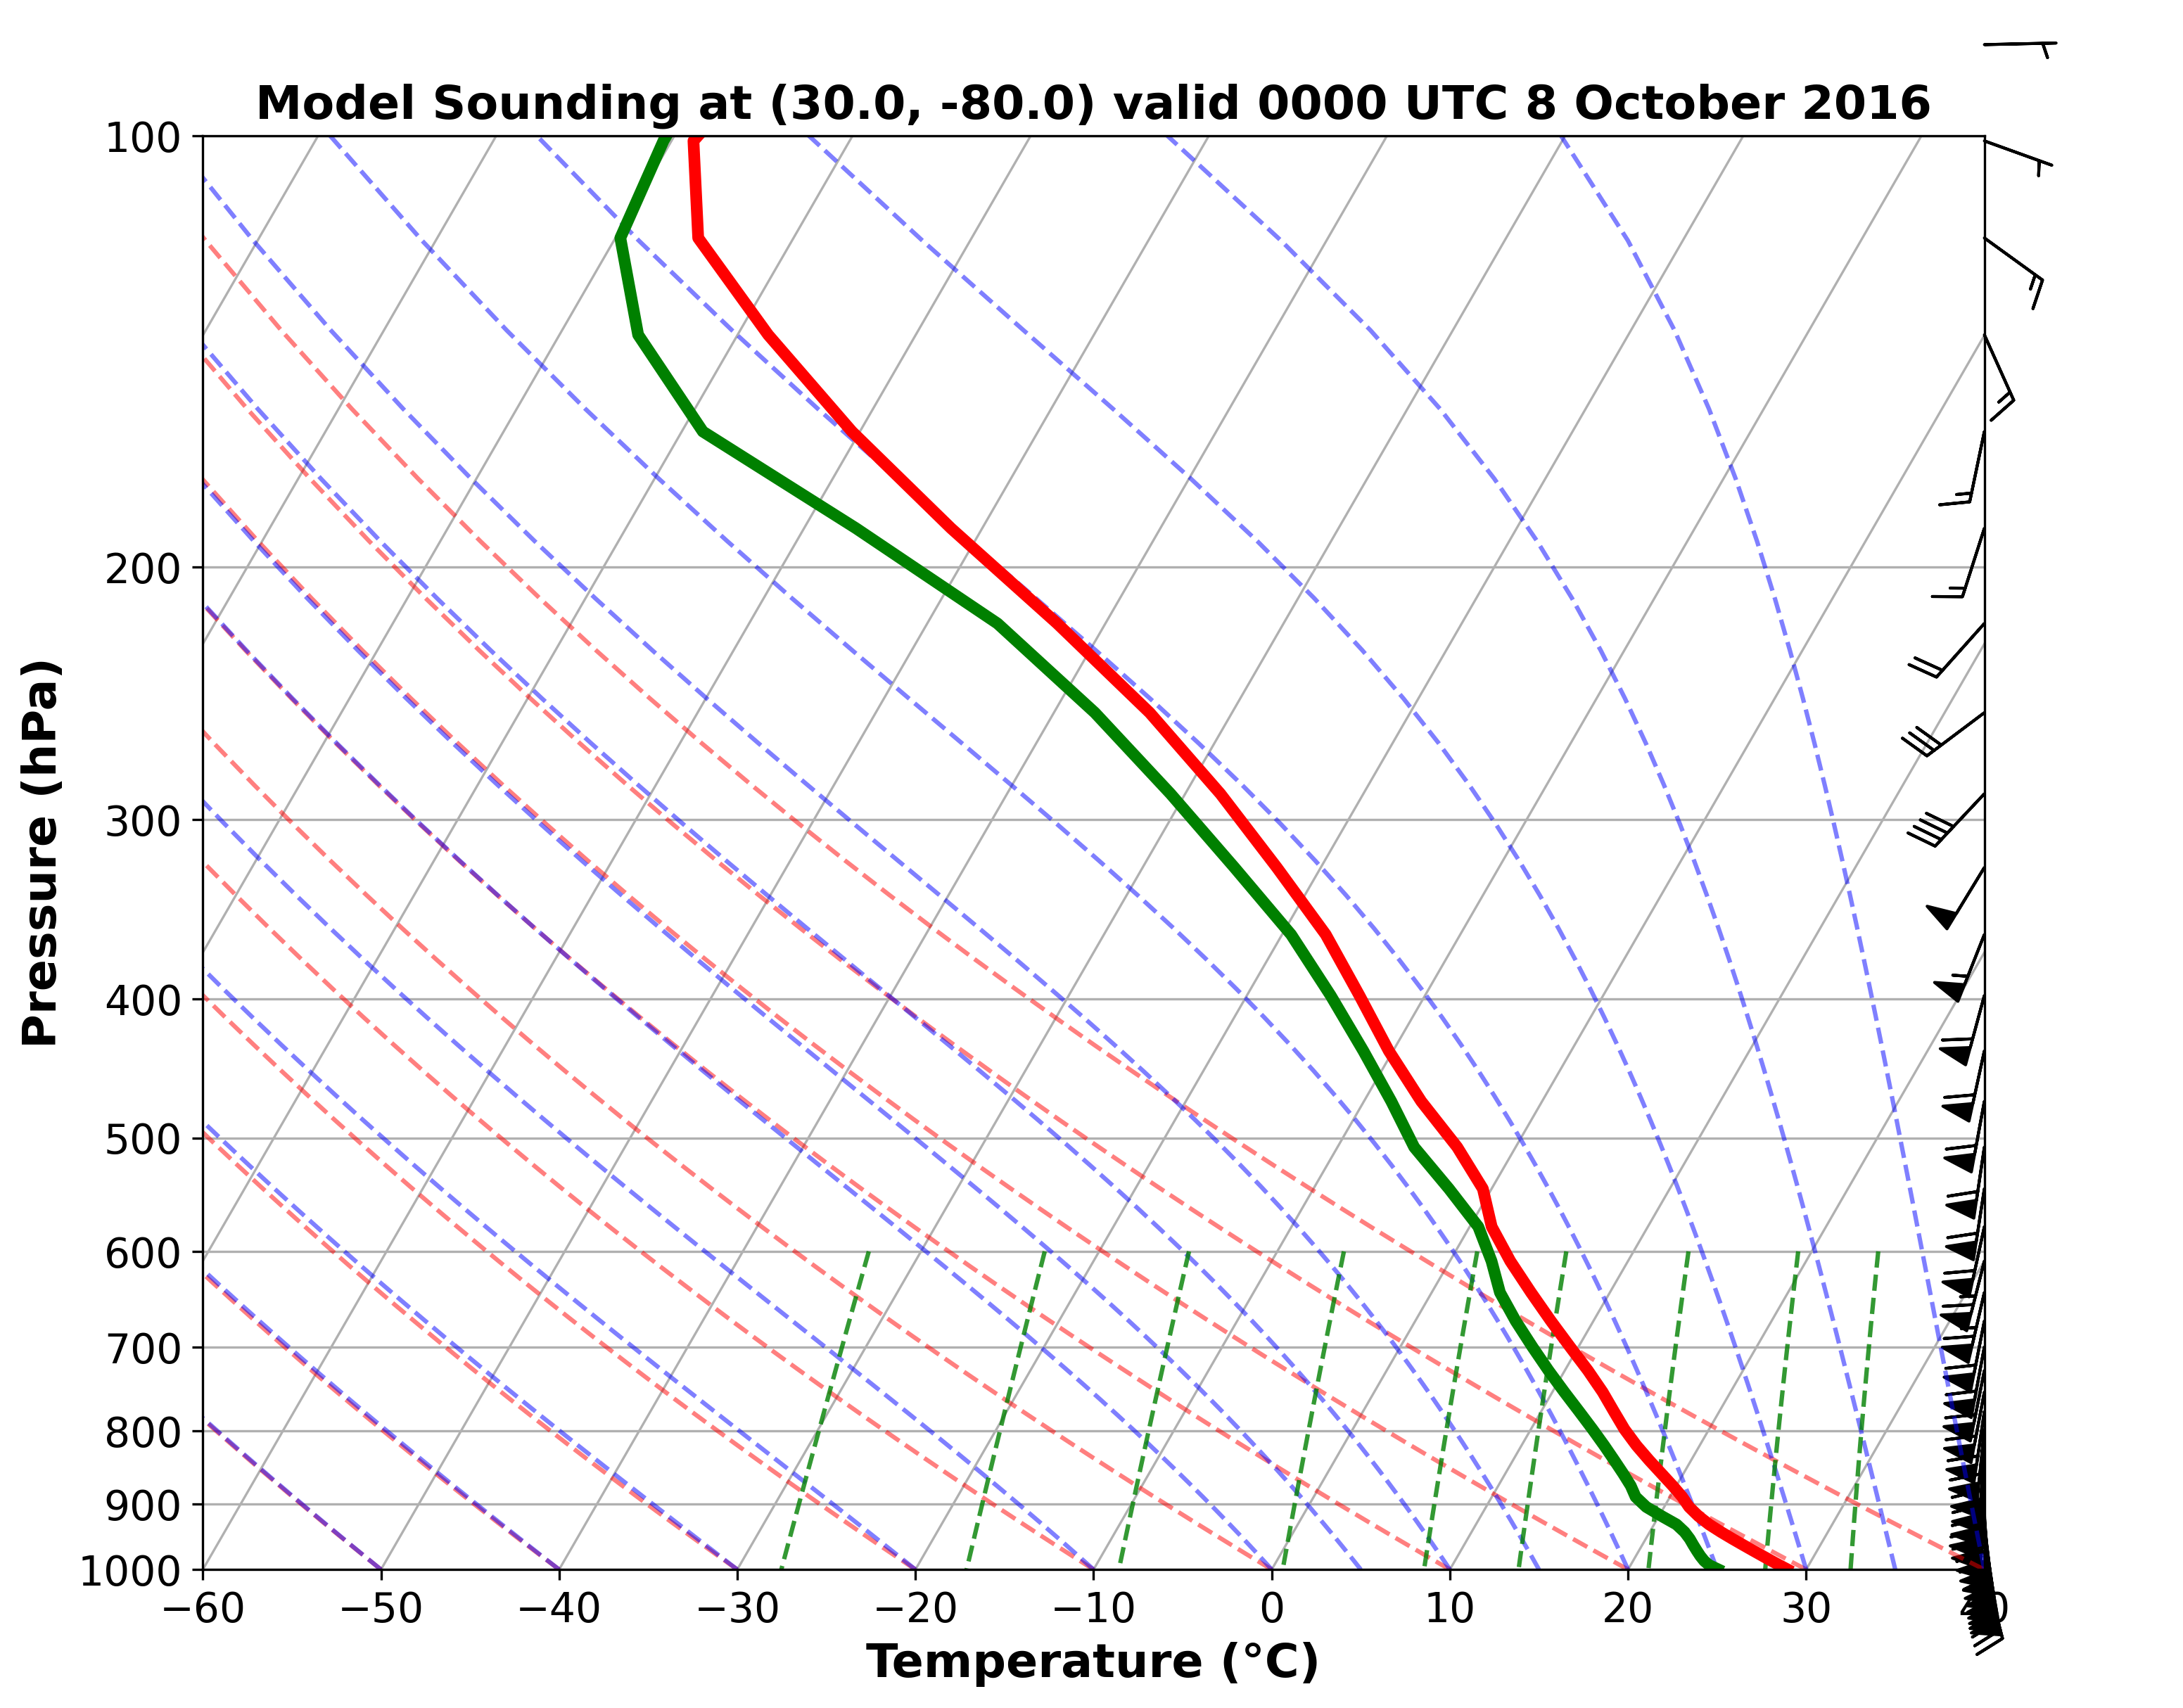

In [6]:
# Create a figure instance, 12" x 9" at 300 dots per inch.
fig = plt.figure(figsize=(12, 9), dpi=300.)

# Ascribe the figure instance to a metpy SkewT object.
skew = SkewT(fig)

# Set the sounding's axis parameters: in this case, -60 to +40 C
# for the skewed x axis and 1000-100 hPa for the logarithmic y axis.
# We also specify to place tick marks and labels on both axes.
skew.ax.set_xlim(-60.,40.)
skew.ax.set_ylim(1000.,100.)
skew.ax.tick_params(axis='both',labelsize=14)

# Plot our fields: temperature, then dewpoint, then winds.
# After doing so, we add a standard set of lines to the
# plot: dry adiabats, moist adiabats (or pseudoadiabats),
# and mixing-ratio lines. Finally, we label the axes and
# give the plot a title.
skew.plot(p,t,'r',linewidth=4)
skew.plot(p,td,'g',linewidth=4)
skew.plot_barbs(p,u,v)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_xlabel("Temperature (°C)", fontsize=16, weight='bold')
skew.ax.set_ylabel("Pressure (hPa)", fontsize=16, weight='bold')
skew.ax.set_title('Model Sounding at (' + str(lat) + ', ' + str(lon) + ') valid 0000 UTC 8 October 2016', fontsize=16, weight='bold')

# Show the image.
plt.show()